
Here we include the neural network model in PyMC3, utilizing Theano tensors to reconstruct the net.

In [1]:
%pylab inline
import pymc3 as pm
import os

os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.parameter import ModelParameters
a=ModelParameters()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load in the neural network weights
model_numpy=np.load("/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun2/stacked_8_element_net.npz")
w_array_0=np.matrix(model_numpy["w0"])
b_array_0=np.matrix(model_numpy["b0"])
w_array_1=np.matrix(model_numpy["w1"])
b_array_1=np.matrix(model_numpy["b1"])
# Load standardization parameters
input_mean=model_numpy.f.in_mean
input_std=model_numpy.f.in_std
output_mean=model_numpy.f.out_mean
output_std=model_numpy.f.out_std

In [3]:
def single_star_output(samples,star_no):
    Lambda=samples.get_values('Lambda')[:,0,:]
    Thetas=samples.get_values('Thetas')[:,star_no,:]
    Times=samples.get_values('Times')[:,0,star_no].reshape(len(Lambda),1)
    return Lambda,Thetas,Times

In [4]:
mock_data=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun2/TNG_Mock_Data_0.30.npz') #dataset
#true_Lambda = mock_data.f.params[0,:2]
#true_Thetas = mock_data.f.params[:,2:5]
true_Times = mock_data.f.true_time
mock_data.close()

In [10]:
# Define priors
Lambda_prior_mean = a.p0[:2]
Theta_prior_mean = a.p0[2:]
Lambda_prior_width = [0.3,0.3]
Theta_prior_width = [0.3,0.1,0.1,0.3]
# Now standardize
std_Lambda_prior_mean = (Lambda_prior_mean-input_mean[:2])/input_std[:2]
std_Lambda_prior_width = (Lambda_prior_width)/input_std[:2]
std_Theta_prior_mean = (Theta_prior_mean-input_mean[2:6])/input_std[2:6]
std_Theta_prior_width = (Theta_prior_width)/input_std[2:6]

# Define critical theta edge:
log_SFR_crit = 0.29402
std_log_SFR_crit = (log_SFR_crit-input_mean[3])/input_std[3]

# Define bounds on age to stop predicting out of parameter space:
min_time,max_time = [0.,13.8]
std_min_time,std_max_time=[(time-input_mean[-1])/input_std[-1] for time in [min_time,max_time]]

import pymc3.math as ma
import theano.tensor as tt




In [ ]:
def n_star_inference(n_stars,iteration,elem_err=False,n_init=20000,n_samples=500,max_stars=100):
    
    ## Define which stars to use
    these_stars = np.arange(max_stars)[iteration*n_stars:(iteration+1)*n_stars]
    
    ## Load in mock dataset
    mock_data=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun2/TNG_Mock_Data_0.30.npz') #dataset
    #n_stars = 100#0#len(mock_data.f.abundances)
    mu_times = mock_data.f.obs_time[these_stars] #time of birth
    sigma_times = mock_data.f.obs_time_err[these_stars] #error on age
    all_els = mock_data.f.elements

    full_abundances = mock_data.f.abundances[these_stars] # chemical element abundances for data
    full_errors = mock_data.f.abundance_errs[these_stars] # error on abundances

    # Filter out correct elements:
    els = ['C','Fe','He','Mg','N','Ne','O','Si'] # TNG elements
    n_els = len(els)
    el_indices=np.zeros(len(els),dtype=int)
    for e,el in enumerate(els):
        for j in range(len(all_els)):
            if els[e]==str(all_els[j]):
                el_indices[e]=j
                break
            if j==len(all_els)-1:
                print("Failed to find element %s"%el)
    obs_abundances = full_abundances[:,el_indices]
    obs_errors = full_errors[:,el_indices]

    #true_Lambda = mock_data.f.params[0,:2]
    #true_Thetas = mock_data.f.params[:,2:5]
    #true_Times = mock_data.f.params[:,-1]

    # Now standardize dataset
    norm_data=(obs_abundances-output_mean)/output_std # use only 6 elements
    norm_sd = obs_errors/output_std

    data_obs = norm_data.ravel()
    data_sd = np.asarray(norm_sd).ravel()

    std_times_mean = (mu_times-input_mean[-1])/input_std[-1]
    std_times_width = sigma_times/input_std[-1]
    
    # Define stacked local priors
    Local_prior_mean = np.vstack([np.hstack([std_Theta_prior_mean,std_times_mean[i]]) for i in range(n_stars)])
    Local_prior_sigma = np.vstack([np.hstack([std_Theta_prior_width,std_times_width[i]]) for i in range(n_stars)])

    
    lowBound = tt._shared(np.asarray([-5,std_log_SFR_crit,-5,-5,std_min_time]))
    upBound = tt._shared(np.asarray([5,5,5,5,std_max_time]))
    
    loc_mean=np.hstack([np.asarray(std_Theta_prior_mean).reshape(1,-1)*np.ones([n_stars,1]),std_times_mean.reshape(-1,1)])
    loc_std=np.hstack([np.asarray(std_Theta_prior_width).reshape(1,-1)*np.ones([n_stars,1]),std_times_width.reshape(-1,1)])
    
    # Share theano variables
    w0=tt._shared(w_array_0)
    b0=tt._shared(b_array_0)
    w1=tt._shared(w_array_1)
    b1=tt._shared(b_array_1)
    ones_tensor = tt.ones([n_stars,1])
    b0_all = ma.matrix_dot(ones_tensor,b0)
    b1_all = ma.matrix_dot(ones_tensor,b1)
    
    simple_model=pm.Model()
    
    with simple_model:
        # Define priors
        Lambda = pm.Normal('Std-Lambda',mu=std_Lambda_prior_mean,
                            sd=std_Lambda_prior_width,
                            shape=(1,len(std_Lambda_prior_mean)))

        Locals = pm.Normal('Std-Local',mu=loc_mean,sd=loc_std,shape=loc_mean.shape,
                          transform=pm.distributions.transforms.Interval(lowBound,upBound),
                           )
        TimeSq = tt.reshape(Locals[:,-1]**2.,(n_stars,1))

        TruLa = pm.Deterministic('Lambda',Lambda*input_std[:2]+input_mean[:2])
        TruTh = pm.Deterministic('Thetas',Locals[:,:4]*input_std[2:6]+input_mean[2:6])
        TruTi = pm.Deterministic('Times',Locals[:,4]*input_std[-1]+input_mean[-1])

        ## NEURAL NET
        Lambda_all = ma.matrix_dot(ones_tensor,Lambda)
        InputVariables = ma.concatenate([Lambda_all,Locals,TimeSq],axis=1)

        layer1 = ma.matrix_dot(InputVariables,w0)+b0_all
        output = ma.matrix_dot(ma.tanh(layer1),w1)+b1_all

        #network_output = pm.Deterministic("Neural Network",output)
        
        if elem_err:
            # ERRORS
            #element_error = pm.Normal('Element-Error',mu=-2,sd=1,shape=(1,n_els))
            element_error = pm.HalfCauchy('Element-Error',beta=0.01,shape=(1,n_els))
            stacked_error = ma.matrix_dot(ones_tensor,element_error)
            tot_error = ma.sqrt(stacked_error**2.+norm_sd**2.)
        else:
            tot_error = norm_sd

        predictions = pm.Deterministic("Predicted-Abundances",output*output_std+output_mean)

        # Define likelihood function (unravelling output to make a multivariate gaussian)
        likelihood=pm.Normal('likelihood', mu=output.ravel(), sd=tot_error.ravel(), 
                             observed=norm_data.ravel())#,total_size=len(norm_data.ravel()))
        
    # Now sample
    import time as ttime
    
    init_time = ttime.time()

    
    with simple_model:
        samples=pm.sample(draws=n_samples,chains=16,cores=16,tune=1500,
                          nuts_kwargs={'target_accept':0.9},init='advi+adapt_diag',n_init=n_init)

    end_time = ttime.time()-init_time

    def construct_output(samples):
        Lambda=samples.get_values('Lambda')[:,0,:]
        Thetas=samples.get_values('Thetas')[:,:,:]
        Times=samples.get_values('Times')[:,:]
        
        predictions = samples.get_values('Predicted-Abundances')[:,:,:]
        
        if elem_err:
            Errs = samples.get_values('Element-Error')[:,0,:]
            return Lambda,Thetas,Times,Errs,predictions
        else:
            return Lambda,Thetas,Times,predictions

    print("Finished after %.2f seconds"%end_time)
    
    if elem_err:
        Lambda,Thetas,Times,Errs,predictions=construct_output(samples)
        return Lambda,Thetas,Times,end_time,Errs,predictions
    else:
        Lambda,Thetas,Times,predictions=construct_output(samples)
        return Lambda,Thetas,Times,end_time,predictions
    

### Now run for various $n_\mathrm{stars}$:

In [ ]:
all_n = [2,5]#[1,2,5,10,20,50,100,200]#,500,1000]#0,50,100]#,50,100]#,]200]#,3,5,7,10]#,15,20,30,40,50,60,70,80,90,100,200]
elem_err=True
chain_params=[]
max_stars = 10
n_init=20000
n_samples=1000
for nn in all_n:
    mini_chain=[]
    for iteration in range(max_stars//nn):
        print("Starting inference using %d stars iteration %d of %d"%(nn,iteration+1,max_stars//nn))
        mini_chain.append(n_star_inference(nn,iteration,elem_err=elem_err,n_init=n_init,
                                           n_samples=n_samples,max_stars=max_stars))
    chain_params.append(mini_chain)

Starting inference using 2 stars iteration 1 of 5


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 12.308:  87%|████████▋ | 17399/20000 [00:17<00:02, 874.83it/s] 
Convergence achieved at 17400
Interrupted at 17,399 [86%]: Average Loss = 122.02
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [Element-Error, Std-Local, Std-Lambda]
Sampling 16 chains: 100%|██████████| 40000/40000 [00:26<00:00, 1491.18draws/s]
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Finished after 69.31 seconds
Starting inference using 2 stars iteration 2 of 5


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 215.36:  17%|█▋        | 3391/20000 [00:01<00:08, 1975.31it/s]
Interrupted at 3,540 [17%]: Average Loss = 325.71
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [Element-Error, Std-Local, Std-Lambda]
Sampling 16 chains: 100%|█████████▉| 39972/40000 [00:30<00:00, 331.29draws/s] /home/oliverphilcox/anaconda3/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Finished after 48.58 seconds
Starting inference using 2 stars iteration 3 of 5


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 9.7104:  73%|███████▎  | 14532/20000 [00:07<00:02, 1943.68it/s]
Convergence achieved at 14700
Interrupted at 14,699 [73%]: Average Loss = 115.86


KeyboardInterrupt: 

In [12]:
all_n = all_n[:len(chain_params)]


In [35]:
chain_params[0][0][2].shape

(16000, 2)

In [43]:
all_Lambda = [[cc[0] for cc in c] for c in chain_params]
all_Thetas = [[cc[1][:,0,:] for cc in c] for c in chain_params]
all_Times = [[cc[2] for cc in c] for c in chain_params]
all_timescale = [[cc[3] for cc in c] for c in chain_params]
if elem_err:
    all_Err = [[cc[4] for cc in c] for c in chain_params]
else:
    all_Err=0.
all_predictions = [[cc[-1] for cc in c] for c in chain_params]

In [65]:
mean_timescale = [np.mean(all_timescale[i],axis=0) for i in range(len(all_timescale))]

In [70]:
#np.savez("/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun/Variable_N_Stars_Mock_Inference_%dpc_HMC"%ERROR,
            #n_stars=all_n,Lambdas=all_Lambda,Thetas=all_Thetas,Times=all_Times,
            #runtimes=all_timescale,Errors=all_Err,mean_runtimes=mean_timescale)

In [55]:
np.mean(np.asarray([np.mean(all_Err[0][i],axis=0) for i in range(5)]),axis=0)

array([0.1711857 , 0.25505006, 0.2681667 , 0.01754939, 0.1794878 ,
       0.02927409, 0.02153468, 0.0403452 ])

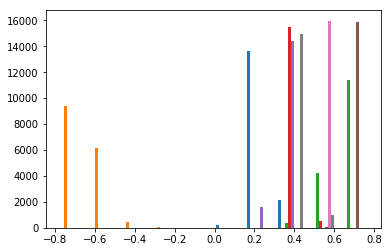

In [57]:
mock_data=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun/TNG_Mock_Data.npz') #dataset
all_els = mock_data.f.elements
true_abun = mock_data.f.true_abuns[0]

plt.hist(all_predictions[0][0][:,1]);

In [58]:
all_els

array(['C', 'Fe', 'He', 'Mg', 'N', 'Ne', 'O', 'Si'], dtype='<U2')

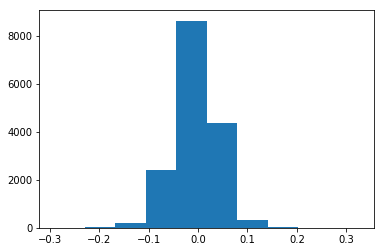

In [60]:
el_index = 1
plt.hist((all_predictions[0][0][:,0,el_index]-true_abun[el_index]).ravel());

In [61]:
all_els

array(['C', 'Fe', 'He', 'Mg', 'N', 'Ne', 'O', 'Si'], dtype='<U2')

nan nan nan 0.0


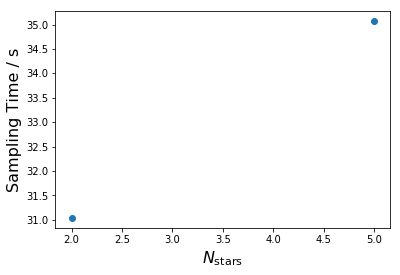

In [69]:
from scipy.stats import linregress
i=0;j=-1
lr=linregress(np.log(all_n[i:j]),np.log(mean_timescale[i:j]))
print(lr.slope,lr.intercept,lr.stderr,lr.rvalue**2.)
plt.scatter(all_n,mean_timescale)
plt.plot(all_n,np.exp(lr.slope*np.log(all_n)+lr.intercept))
plt.xlabel(r'$N_\mathrm{stars}$',fontsize=16);plt.ylabel('Sampling Time / s',fontsize=16);
#plt.xscale('log');plt.yscale('log')

Load both datasets:

In [16]:
dat1=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun/Variable_N_Stars_Mock_Inference_1pc.npz')
all_Lambda1=dat1.f.Lambdas
all_n1=dat1.f.n_stars
dat10=np.load('/mnt/store1/oliverphilcox/ChempyMultiData/TNG_Abun/Variable_N_Stars_Mock_Inference_10pc_HMC.npz')
all_Lambda10=dat10.f.Lambdas
all_n10=dat10.f.n_stars
dat1.close()
dat10.close()

In [17]:
def percs(dat,all_n,index):
    med=np.asarray([np.median(dat[i][:,index],axis=0) for i in range(len(all_n))])
    lo=np.asarray([np.percentile(dat[i][:,index],15.865,axis=0) for i in range(len(all_n))])
    hi=np.asarray([np.percentile(dat[i][:,index],100.-15.865,axis=0) for i in range(len(all_n))])
    return med,med-lo,hi-med

NameError: name 'true_Lambda' is not defined

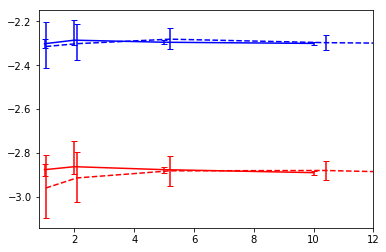

In [18]:
d1_0=percs(all_Lambda1,all_n1,0)
d1_1=percs(all_Lambda1,all_n1,1)
d10_0=percs(all_Lambda10,all_n10,0)
d10_1=percs(all_Lambda10,all_n10,1)
cols=['b','r']

plt.errorbar(all_n1,d1_0[0],yerr=[d1_0[1],d1_0[2]],label=r'$\alpha_\mathrm{IMF}$',c=cols[0],capsize=3)
plt.errorbar(all_n1,d1_1[0],yerr=[d1_1[1],d1_1[2]],label=r'$\log_{10}\mathrm{N}_\mathrm{Ia}$',c=cols[1],capsize=3)
plt.errorbar(all_n10*1.04,d10_0[0],yerr=[d10_0[1],d10_0[2]],ls='--',c=cols[0],capsize=3)
plt.errorbar(all_n10*1.04,d10_1[0],yerr=[d10_1[1],d10_1[2]],ls='--',c=cols[1],capsize=3)

plt.xlim([0.8*min(all_n1),1.2*max(all_n1)])

plt.hlines(true_Lambda[0],0.1,1000,linestyles=':',alpha=0.8)
plt.hlines(true_Lambda[1],0.1,1000,linestyles=':',alpha=0.8)

plt.legend(fontsize=14,loc='center right');plt.xlabel(r'$n_\mathrm{stars}$',fontsize=16);
plt.ylabel('Parameter Estimate',fontsize=16);
plt.xscale('log');

plt.savefig('Plots/MockChempyParameterConvergenceHMC.pdf',bbox_inches='tight')

In [31]:
pm.model_to_graphviz(simple_model)

NameError: name 'simple_model' is not defined

In [32]:
pm.summary(samples,varnames=['Lambda']).round(4)

NameError: name 'samples' is not defined

In [21]:
true_Lambda

NameError: name 'true_Lambda' is not defined

In [22]:
pm.traceplot(samples,varnames=['Lambda','Thetas','Times']);

NameError: name 'samples' is not defined

In [627]:
Lambda,Thetas,Times=construct_output(samples)

Corner Plot for All Stars

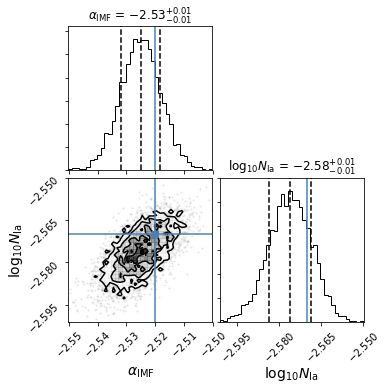

In [628]:
import corner
corner.corner(Lambda,show_titles=True,quantiles=[0.17,0.5,0.83],use_math_text=True,label_kwargs={'fontsize': 14},
              labels=[r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$'],bins=40,truths=true_Lambda);

Corner plot for single star (with $1\sigma$ Gaussian smoothing):

In [629]:
from scipy.stats import truncnorm

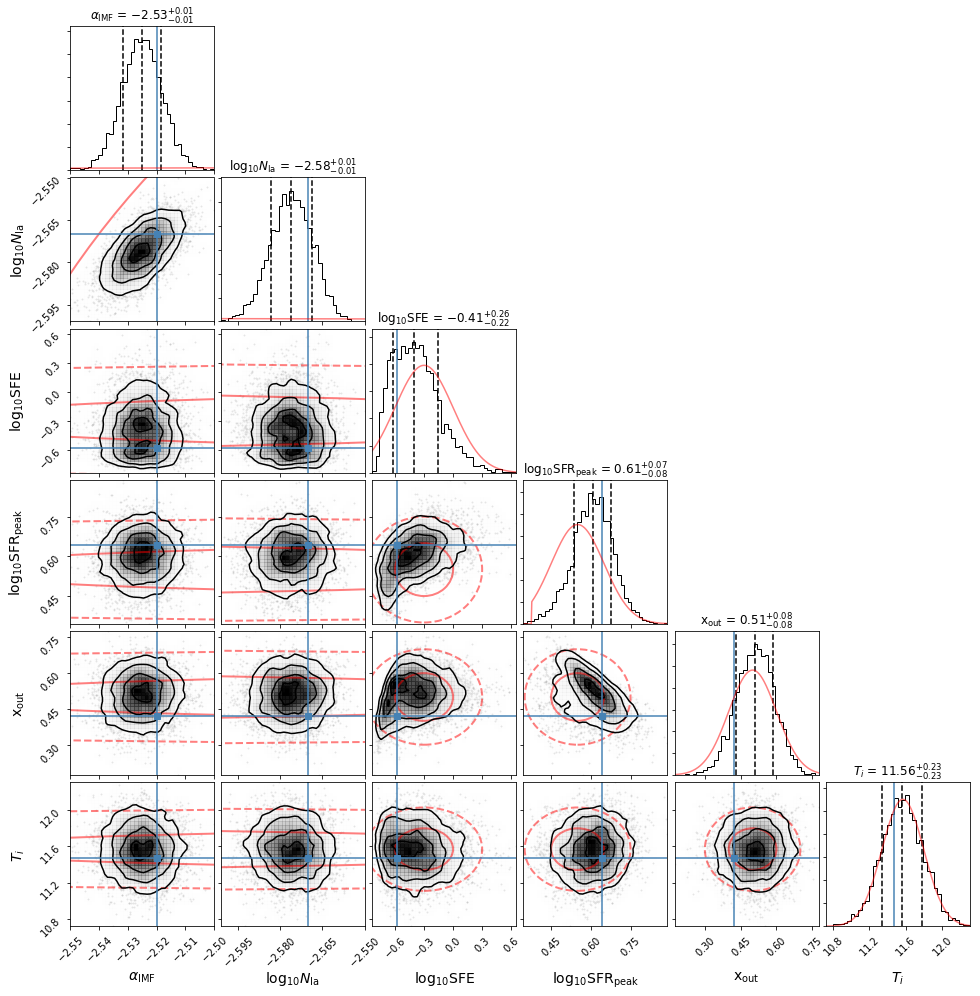

In [630]:
star_index=2
Lambda,Theta1,Times1=single_star_output(samples,star_index)

true_params = np.hstack([true_Lambda,true_Thetas[star_index],true_Times[star_index]])

n_bins=40
names = [r'$\alpha_\mathrm{IMF}$',r'$\log_{10}N_\mathrm{Ia}$',r'$\log_{10}\mathrm{SFE}$',
         r'$\log_{10}\mathrm{SFR}_\mathrm{peak}$',r'$\mathrm{x}_\mathrm{out}$',r'$T_i$']
priors = list(a.p0)+[mu_times[star_index]]
prior_widths = list(np.hstack([Lambda_prior_width,Theta_prior_width]))+[sigma_times[star_index]]
all_dat=np.hstack([Lambda,Theta1,Times1])
figure=corner.corner(all_dat,show_titles=True,quantiles=[0.17,0.5,0.83],truths=true_params,
                     use_math_text=True,label_kwargs={'fontsize': 14},
                     labels=names,bins=n_bins,scale_hist=False,smooth=1.);

integ=np.zeros(len(all_dat[0]))
for i in range(len(all_dat[0])):
    ct,x,=np.histogram(all_dat[:,i],bins=n_bins)
    integ[i]=np.sum(np.diff(x)*ct)

from matplotlib.patches import Ellipse

# Extract the axes
ndim=len(priors)
axes = np.array(figure.axes).reshape((ndim, ndim))

from scipy.stats import norm

for yi in range(ndim):
    xi=yi
    ax=axes[yi,xi]
    xdata=np.linspace(priors[xi]-10*prior_widths[xi],priors[xi]+10*prior_widths[xi],1000)
    if yi==3:
        ax.plot(xdata,integ[yi]*truncnorm.pdf(xdata,std_log_SFR_crit,np.inf,loc=priors[xi],scale=prior_widths[xi]),c='r',alpha=0.5)
    else:
        ax.plot(xdata,integ[yi]*norm.pdf(xdata,loc=priors[xi],scale=prior_widths[xi]),c='r',alpha=0.5)

# Loop over the histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        el=Ellipse([priors[xi],priors[yi]],2*prior_widths[xi],2*prior_widths[yi],
                   facecolor='none',edgecolor='r', lw=2,alpha=0.5)
        el2=Ellipse([priors[xi],priors[yi]],4*prior_widths[xi],4*prior_widths[yi],
                   facecolor='none',edgecolor='r', lw=2,alpha=0.5,ls='--')
        ax.add_artist(el)
        ax.add_artist(el2)

In [631]:
def plotautocorr(samples,max_lags=30,burn_in=100):
    FS=16
    lambda_samples=samples['Lambda'][:,0,:][burn_in:]
    fig,ax=plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True)
    for l,lam in enumerate(lambda_samples.T):
        ax[l].acorr(lam, detrend=plt.mlab.detrend_mean,maxlags=max_lags)
        ax[l].set_ylabel(r"$\Lambda_{%d}$"%(l+1),fontsize=FS)
        ax[l].set_xlim(0, max_lags)

    ax[1].set_xlabel("Lag",fontsize=FS)
    ax[0].set_title(r"$\Lambda$ Autocorrelation Plot using %d burn-in samples"%burn_in,fontsize=FS);   

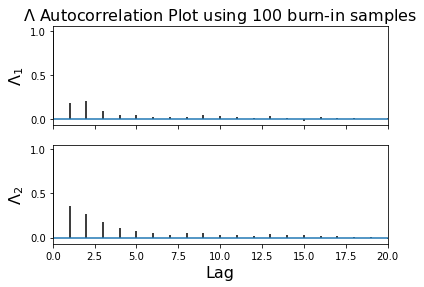

In [632]:
plotautocorr(samples,burn_in=100,max_lags=20);

Plot PPC:

In [633]:
def net_standard_output(standard_in_par):
    """Return neural network output (in standardized form)"""
    l1=np.matmul(np.asmatrix(standard_in_par),w_array_0)+b_array_0
    standard_out=np.matmul(np.tanh(l1),w_array_1)+b_array_1
    return np.asarray(standard_out)
def net_output(in_par):
    """Return physics neural network output for destandardized parameters"""
    # Standardize input:
    standard_in=(in_par-input_mean)/input_std
    sq_in = np.asarray(list(standard_in)+[standard_in[-1]**2.])
    # Reconstruct network
    standard_out=net_standard_output(sq_in)
    # Destandardize output
    out = np.asarray(standard_out)*output_std+output_mean
    return out

#### Let's see what's happening for star 4 (at large time)

In [634]:
La,Th,Ti = single_star_output(samples,4)
params=np.hstack([La,Th,Ti])
med_params=np.median(params,axis=0)
true_params=np.hstack([true_Lambda,true_Thetas[4],true_Times[4]])
print(med_params)
print(true_params)

[-2.52506358 -2.57603612 -0.07483571  0.53786689  0.49610629  4.67474499]
[-2.52       -2.57       -0.26498553  0.59576501  0.47124106  5.34128215]


In [635]:
all_ppc_abun=[]
for star_index in range(n_stars):
    Lambda,Theta1,Times1=single_star_output(samples,star_index)
    all_par=np.hstack([Lambda,Theta1,Times1])
    ppc_abun = np.asarray([net_output(pp) for pp in all_par])
    all_ppc_abun.append(ppc_abun)

In [636]:
all_ppc_abun[0].shape

(4000, 1, 6)

In [638]:
def alpha_abun(abun_arr,err=False):
    for e in range(len(els)):
        if str(els[e])=='O':
            indO=e
        if str(els[e])=='Mg':
            indMg=e
        if str(els[e])=='Si':
            indSi=e
        if str(els[e])=='Fe':
            indFe=e
    if err:
        ab_alpha = np.sqrt(abun_arr[indFe]**2.+((abun_arr[indO]*16.)**2.+(abun_arr[indMg]*24.)**2.+(abun_arr[indSi]*28.)**2.)/(16.+24.+28.)**2.)
    else:
        ab_alpha = (abun_arr[indO]*16.+abun_arr[indMg]*24.+abun_arr[indSi]*28.)/(16.+24.+28.)-abun_arr[indFe]
    return abun_arr[indFe],ab_alpha

In [639]:
ppc_perc

array([[ 0.34701237, -0.34231676, -0.68917089, -0.42324484, -0.29199205,
         0.02611988],
       [ 0.36717024, -0.32497162, -0.67112657, -0.40015309, -0.268486  ,
         0.03307084],
       [ 0.38792406, -0.30812993, -0.65532162, -0.37902364, -0.24338104,
         0.04015582]])

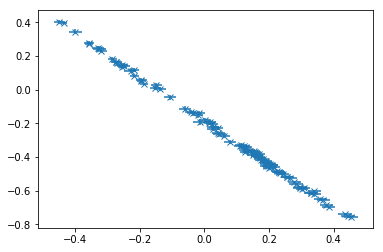

In [643]:
up,med,lo=[],[],[]
for i in range(n_stars):
    ppc_perc = np.percentile(all_ppc_abun[i][:,0,:],[17.,50.,83.],axis=0)
    med.append(alpha_abun(ppc_perc[1]))
    up.append(alpha_abun(ppc_perc[2]))
    lo.append(alpha_abun(ppc_perc[0]))
med=np.asarray(med)
up=np.asarray(up)
lo=np.asarray(lo)
plt.errorbar(med[:,0],med[:,1],yerr=[med[:,1]-lo[:,1],up[:,1]-med[:,1]],
             xerr=[med[:,0]-lo[:,0],up[:,0]-med[:,0]],marker='x',ls='')
obs_dat=[];obs_err=[]
for i in range(n_stars):
    obs_dat.append(alpha_abun(obs_abundances[i]))
    obs_err.append(alpha_abun(obs_errors[i],err=True))
#plt.errorbar(np.asarray(obs_dat)[:,0],np.asarray(obs_dat)[:,1],marker='x',ls='',
#            yerr=np.asarray(obs_err)[:,1],xerr=np.asarray(obs_err)[:,0])


In [641]:
np.asarray(obs_dat)

array([[ 0.10410396, -0.32357946],
       [ 0.01857104, -0.22495374],
       [ 0.28749466, -0.54941304],
       [ 0.29762135, -0.57063718],
       [ 0.01971727, -0.20448276],
       [ 0.33138855, -0.60489113],
       [-0.30542443,  0.20772998],
       [ 0.22602218, -0.47217897],
       [ 0.23880379, -0.50325929],
       [-0.21917254,  0.07715337],
       [-0.05110679, -0.12165105],
       [ 0.3095843 , -0.58353412],
       [ 0.22821273, -0.50049899],
       [ 0.14526111, -0.36278229],
       [-0.20980921,  0.07628836],
       [ 0.1208396 , -0.34104413],
       [ 0.07532282, -0.29484   ],
       [ 0.33165699, -0.6111201 ],
       [ 0.04016296, -0.21558046],
       [ 0.01576877, -0.19392499],
       [ 0.12146679, -0.36864375],
       [ 0.03521389, -0.25249035],
       [ 0.17053273, -0.40554509],
       [ 0.15963727, -0.3877517 ],
       [-0.15569308,  0.02587724],
       [ 0.26642709, -0.52706133],
       [-0.32274231,  0.22712853],
       [ 0.19426086, -0.44873852],
       [-0.06925373,

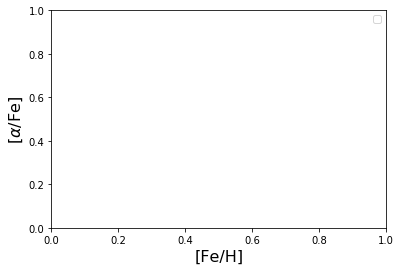

In [642]:
len_T = len(np.unique(true_Times))
labels = ['Vanilla','Low SFE','Bursty SFR','Leaky ISM']
c=['k','r','g','b']
for index in range(n_stars//len_T):
    oFeH,oAlFe,oFeHSig,oAlFeSig=[np.zeros(len_T) for _ in range(4)]
    FeH,AlFe,FeHL,FeHH,AlFeL,AlFeH=[np.zeros(len_T) for _ in range(6)]
    for j in range(len_T):
        star_index = index*len_T+j
        this_ppc_perc = np.percentile(all_ppc_abun[star_index][:,0,:],[17.,50.,83.],axis=0)
        oFeH[j],oAlFe[j] = alpha_abun(obs_abundances[star_index])
        oFeHSig[j],oAlFeSig[j] = alpha_abun(obs_errors[star_index],err=True)
        FeH[j],AlFe[j] = alpha_abun(this_ppc_perc[1])
        FeHL[j],AlFeL[j] = alpha_abun(this_ppc_perc[0])
        FeHH[j],AlFeH[j] = alpha_abun(this_ppc_perc[2])
    plt.errorbar(oFeH,oAlFe,xerr=oFeHSig,yerr=oAlFeSig,ls='--',label=labels[index],c=c[index],alpha=0.1)
    plt.errorbar(FeH,AlFe,xerr=[FeH-FeHL,FeHH-FeH],yerr=[AlFe-AlFeL,AlFeH-AlFe],ls='-',c=c[index])
plt.legend();plt.ylabel(r'[$\alpha$/Fe]',fontsize=16);plt.xlabel('[Fe/H]',fontsize=16);